# SECTION 5 : PRÉTRAITEMENT DES IMAGES




### 1.Import

In [61]:

import os
import sys
import yaml
import random
import shutil
from pathlib import Path
from collections import Counter
import pickle
import json
import time
from datetime import datetime

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

from tqdm import tqdm










print(" imports OK")
print(f"TensorFlow : {tf.__version__}")







 imports OK
TensorFlow : 2.20.0


In [63]:
# ============================================================================
# NETTOYAGE COMPLET DE data/processed/
# ============================================================================

import shutil
from pathlib import Path

print("=" * 80)
print(" NETTOYAGE DE data/processed/")
print("=" * 80)
print()

PROCESSED_DIR = Path(r"A:\Mes documents\CNN\data\processed")

# Supprimer train/
if (PROCESSED_DIR / "train").exists():
    print("Suppression de train/...")
    shutil.rmtree(PROCESSED_DIR / "train")
    print(" train/ supprimé")

# Supprimer validation/
if (PROCESSED_DIR / "validation").exists():
    print("Suppression de validation/...")
    shutil.rmtree(PROCESSED_DIR / "validation")
    print(" validation/ supprimé")

print()
print(" NETTOYAGE TERMINÉ !")
print("=" * 80)

 NETTOYAGE DE data/processed/


 NETTOYAGE TERMINÉ !


### 2.Chargement 

In [64]:
CONFIG_PATH = Path(r"A:/Mes documents/CNN/config.yaml")

if not CONFIG_PATH.exists():
    raise FileNotFoundError(f"config.yaml introuvable : {CONFIG_PATH}")

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

print(" Config chargée")

#  params 
BASE_DIR = Path(config["paths"]["base_dir"])
outputs_cfg = config["paths"]["outputs"]

if isinstance(outputs_cfg, dict):
    OUTPUTS_DIR = BASE_DIR / "outputs"
else:
    OUTPUTS_DIR = BASE_DIR / outputs_cfg

FIGURES_DIR = OUTPUTS_DIR / "figures"
TRAINING_FIGURES_DIR = FIGURES_DIR / "training"

TRAINING_FIGURES_DIR.mkdir(parents=True, exist_ok=True)




# Data
DATA_CFG = config["data"]
IMAGE_SIZE = tuple(DATA_CFG["image_size"])
BATCH_SIZE = DATA_CFG["batch_size"]
TRAIN_VAL_SPLIT = DATA_CFG["train_val_split"]
RANDOM_SEED = DATA_CFG["random_seed"]

CLASSES = config["classes"]
N_CLASSES = DATA_CFG["n_classes"]

# Fixage  des seeds
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


 Config chargée


### 3. Création de la structure train/validation

In [65]:
from pathlib import Path

BALANCED_DATA_PATH = Path(r"A:\Mes documents\CNN\data\balanced\simpsons_balanced")

print("Contenu du dossier équilibré :")
for d in BALANCED_DATA_PATH.iterdir():
    print(d.name)


Contenu du dossier équilibré :
abraham_grampa_simpson
bart_simpson
charles_montgomery_burns
chief_wiggum
homer_simpson
krusty_the_clown
lisa_simpson
marge_simpson
milhouse_van_houten
moe_szyslak
ned_flanders
principal_skinner
sideshow_bob


In [66]:
print(" Création structure train / validation")

PROCESSED_TRAIN_PATH = BASE_DIR / "data" / "processed" / "train"
PROCESSED_VAL_PATH = BASE_DIR / "data" / "processed" / "validation"
BALANCED_DATA_PATH = BASE_DIR / "data" / "balanced" / "simpsons_balanced"
MODELS_DIR = BASE_DIR / "models"

PROCESSED_TRAIN_PATH.mkdir(parents=True, exist_ok=True)
PROCESSED_VAL_PATH.mkdir(parents=True, exist_ok=True)

split_counts = {}  # pour stocker le nombre d'images par classe

for class_name in tqdm(CLASSES, desc="Split classes"):
    source_dir = BALANCED_DATA_PATH / class_name
    if not source_dir.exists():
        raise FileNotFoundError(f"Classe manquante : {class_name}")

    images = list(source_dir.glob("*.jpg")) + list(source_dir.glob("*.png"))
    images = list(set(images))

    # Shuffle image obligatoire avant split
    random.shuffle(images)

    n_train = int(len(images) * TRAIN_VAL_SPLIT)
    train_imgs = images[:n_train]
    val_imgs = images[n_train:]

    train_dest = PROCESSED_TRAIN_PATH / class_name
    val_dest = PROCESSED_VAL_PATH / class_name
    train_dest.mkdir(parents=True, exist_ok=True)
    val_dest.mkdir(parents=True, exist_ok=True)

    for img in train_imgs:
        dst = train_dest / img.name
        if not dst.exists():
            shutil.copy2(img, dst)

    for img in val_imgs:
        dst = val_dest / img.name
        if not dst.exists():
            shutil.copy2(img, dst)

    # Stocker le compte
    split_counts[class_name] = {'train': len(train_imgs), 'val': len(val_imgs)}

print(" Split terminé\n")

# Mon nombre d'images par classe 
total_train = total_val = 0
print("Nombre d'images par classe après split :")
for class_name, counts in split_counts.items():
    print(f"{class_name:30s} | Train: {counts['train']:4d} | Val: {counts['val']:4d}")
    total_train += counts['train']
    total_val += counts['val']

print("-" * 50)
print(f"{'TOTAL':30s} | Train: {total_train:4d} | Val: {total_val:4d}")


 Création structure train / validation


Split classes: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]

 Split terminé

Nombre d'images par classe après split :
abraham_grampa_simpson         | Train:  680 | Val:  170
bart_simpson                   | Train:  680 | Val:  170
charles_montgomery_burns       | Train:  680 | Val:  170
chief_wiggum                   | Train:  680 | Val:  170
homer_simpson                  | Train:  680 | Val:  170
krusty_the_clown               | Train:  680 | Val:  170
lisa_simpson                   | Train:  680 | Val:  170
marge_simpson                  | Train:  680 | Val:  170
milhouse_van_houten            | Train:  680 | Val:  170
moe_szyslak                    | Train:  680 | Val:  170
ned_flanders                   | Train:  680 | Val:  170
principal_skinner              | Train:  680 | Val:  170
sideshow_bob                   | Train:  680 | Val:  170
--------------------------------------------------
TOTAL                          | Train: 8840 | Val: 2210


# SECTION 6 : DATA AUGMENTATION




### 1. Configuration de l'augmentation

In [67]:
from PIL import Image, ImageEnhance
import random

AUGMENTED_DIR = BASE_DIR / "data" / "augmented"
AUGMENTED_DIR.mkdir(parents=True, exist_ok=True)

def augment_image(img_path, save_dir, n_augments=3):
    """Augmente une image et la sauvegarde"""
    with Image.open(img_path) as img:
        for i in range(n_augments):
            aug = img.copy()
            
            # Flip horizontal
            if random.random() > 0.5:
                aug = aug.transpose(Image.FLIP_LEFT_RIGHT)
            
            # Rotation légère
            angle = random.uniform(-15, 15)
            aug = aug.rotate(angle)
            
            # Zoom / crop + resize
            w, h = aug.size
            scale = random.uniform(0.9, 1.1)
            new_w, new_h = int(w*scale), int(h*scale)
            aug = aug.resize((new_w, new_h), Image.LANCZOS)
            aug = aug.crop((0, 0, w, h)).resize((w, h), Image.LANCZOS)
            
            # Luminosité / contraste
            if random.random() > 0.5:
                enhancer = ImageEnhance.Brightness(aug)
                aug = enhancer.enhance(random.uniform(0.8, 1.2))
            if random.random() > 0.5:
                enhancer = ImageEnhance.Contrast(aug)
                aug = enhancer.enhance(random.uniform(0.8, 1.2))
            
            # Sauvegarde
            save_path = save_dir / f"{img_path.stem}_aug{i}{img_path.suffix}"
            aug.save(save_path)

# Application sur toutes les classes
for class_name in CLASSES:
    src_dir = PROCESSED_TRAIN_PATH / class_name
    dst_dir = AUGMENTED_DIR / class_name
    dst_dir.mkdir(parents=True, exist_ok=True)

    images = list(src_dir.glob("*.jpg")) + list(src_dir.glob("*.png"))
    
    for img_path in images:
        augment_image(img_path, dst_dir, n_augments=2)  # 2 img ajoutées  par image existante

print("Data augmentation terminée ")


Data augmentation terminée 


### 3.  Visualisation de l'augmentation

In [68]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Choisir une classe aléatoirement (ou une classe spécifique)
sample_class = CLASSES[0]
sample_class_path = PROCESSED_TRAIN_PATH / sample_class

# Récupérer les images disponibles
sample_images = list(sample_class_path.glob("*.jpg")) + list(sample_class_path.glob("*.png"))

if sample_images:
    sample_img_path = random.choice(sample_images)
    
    # Charger l'image
    img = Image.open(sample_img_path).resize(IMAGE_SIZE)
    
    # Fonction d'augmentation (version simple pour visualisation)
    def augment_for_viz(img):
        aug = img.copy()
        if random.random() > 0.5:
            aug = aug.transpose(Image.FLIP_LEFT_RIGHT)
        angle = random.uniform(-15, 15)
        aug = aug.rotate(angle)
        # Luminosité
        enhancer = ImageEnhance.Brightness(aug)
        aug = enhancer.enhance(random.uniform(0.8, 1.2))
        # Contraste
        enhancer = ImageEnhance.Contrast(aug)
        aug = enhancer.enhance(random.uniform(0.8, 1.2))
        return aug

    # Générer 8 images augmentées
    augmented_images = [augment_for_viz(img) for _ in range(8)]
    
    # Affichage
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle(f'Exemples de Data Augmentation - {sample_class}', 
                 fontsize=16, fontweight='bold')
    
    # Image originale
    axes[0, 0].imshow(img)
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')
    
    # Images augmentées
    for i, aug_img in enumerate(augmented_images):
        row = (i + 1) // 3
        col = (i + 1) % 3
        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(f'Augmentation {i+1}', fontweight='bold')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    
    # Créer le dossier si nécessaire
    TRAINING_FIGURES_DIR.mkdir(parents=True, exist_ok=True)
    save_path = TRAINING_FIGURES_DIR / '01_data_augmentation_examples.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Graphique sauvegardé dans : {save_path}")
    plt.close()


Graphique sauvegardé dans : A:\Mes documents\CNN\outputs\figures\training\01_data_augmentation_examples.png


# SECTION 7 : CNN FROM SCRATCH




### 1. Construction 

In [70]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=config['augmentation']['rotation_range'],
    width_shift_range=config['augmentation']['width_shift_range'],
    height_shift_range=config['augmentation']['height_shift_range'],
    zoom_range=config['augmentation']['zoom_range'],
    horizontal_flip=config['augmentation']['horizontal_flip'],
    brightness_range=config['augmentation']['brightness_range'],
    fill_mode=config['augmentation']['fill_mode']
)

# 
val_datagen = ImageDataGenerator(rescale=1./255)

# Générateurs
train_generator = train_datagen.flow_from_directory(
    directory=PROCESSED_TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=config['data']['batch_size'],
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=PROCESSED_VAL_PATH,
    target_size=IMAGE_SIZE,
    batch_size=config['data']['batch_size'],
    class_mode='categorical',
    shuffle=False
)


Found 8840 images belonging to 13 classes.
Found 2210 images belonging to 13 classes.


In [71]:
#definition du modele 
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

cnn_config = config['cnn_scratch']

def build_cnn():
    model = models.Sequential([
        layers.Conv2D(cnn_config['filters'][0], (3,3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(cnn_config['filters'][1], (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(cnn_config['filters'][2], (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(cnn_config['filters'][3], (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(cnn_config['dense_units'], activation='relu'),
        layers.Dropout(cnn_config['dropout_rate']),
        layers.Dense(N_CLASSES, activation='softmax') 
    ])
    return model

cnn_model = build_cnn()
cnn_model.summary()


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │         6,669 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,271,885 (73.52 MB)

 Trainable params: 19,270,925 (73.51 MB)

 Non-trainable params: 960 (3.75 KB)

In [72]:
for layer in cnn_model.layers:
    print(layer.name, layer.trainable, layer.count_params())


conv2d_8 True 896
max_pooling2d_8 True 0
batch_normalization_8 True 128
conv2d_9 True 18496
max_pooling2d_9 True 0
batch_normalization_9 True 256
conv2d_10 True 73856
max_pooling2d_10 True 0
batch_normalization_10 True 512
conv2d_11 True 295168
max_pooling2d_11 True 0
batch_normalization_11 True 1024
flatten_2 True 0
dense_4 True 18874880
dropout_2 True 0
dense_5 True 6669


In [73]:
#callbacks 
cnn_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=config['callbacks']['early_stopping']['patience'],
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    ),
    ModelCheckpoint(
       str(MODELS_DIR / 'cnn_scratch.keras'),   
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [74]:
#compilation 
optimizer = optimizers.Adam(learning_rate=cnn_config['learning_rate'])

cnn_model.compile(
    optimizer=optimizer,
    loss=cnn_config['loss'],
    metrics=['accuracy']
)


### 2. Entraînement

In [75]:

# Entraînement
start = time.time()
history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  
    callbacks=cnn_callbacks,
    verbose=1
)
temps_cnn = time.time() - start

print()
print(f" CNN terminé en {temps_cnn/60:.1f} minutes")
print(f"Val Accuracy: {max(history.history['val_accuracy']):.4f}")
print()

Epoch 1/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2269 - loss: 9.9558
Epoch 1: val_accuracy improved from None to 0.10950, saving model to A:\Mes documents\CNN\models\cnn_scratch.keras

Epoch 1: finished saving model to A:\Mes documents\CNN\models\cnn_scratch.keras
277/277 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.2512 - loss: 7.6588 - val_accuracy: 0.1095 - val_loss: 5.2114 - learning_rate: 0.0010
Epoch 2/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3290 - loss: 3.0232
Epoch 2: val_accuracy improved from 0.10950 to 0.45611, saving model to A:\Mes documents\CNN\models\cnn_scratch.keras

Epoch 2: finished saving model to A:\Mes documents\CNN\models\cnn_scratch.keras
277/277 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.3499 - loss: 2.5768 - val_accuracy: 0.4561 - val_loss: 1.8185 - learning_rate: 0.0010
Epoch 3/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4314 - loss: 1.8817
Epoch 3: val_accuracy improved from 0.45611 to 0.55611, saving mod

In [76]:
 
# sauvegarde 
import pickle

history_path = MODELS_DIR / 'training_history' / 'cnn_scratch_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Historique d'entraînement sauvegardé : {history_path}")


Historique d'entraînement sauvegardé : A:\Mes documents\CNN\models\training_history\cnn_scratch_history.pkl


## 3.Visualisations

In [77]:


import matplotlib.pyplot as plt
import time



# Si tu veux mesurer le temps
training_time_cnn = time.time() - start  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('CNN From Scratch - Accuracy', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('CNN From Scratch - Loss', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Chemin pour sauvegarder
save_path = TRAINING_FIGURES_DIR / '02_cnn_scratch_training.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f" Graphique sauvegardé dans : {save_path}")
plt.close()

# Afficher les métriques finales
final_train_acc = history.history['accuracy'][-1]
final_val_acc   = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss   = history.history['val_loss'][-1]

print()
print(" Métriques finales:")
print(f"  Train Accuracy : {final_train_acc:.4f}")
print(f"  Val Accuracy   : {final_val_acc:.4f}")
print(f"  Train Loss     : {final_train_loss:.4f}")
print(f"  Val Loss       : {final_val_loss:.4f}")
print(f"  Temps approx.  : {training_time_cnn/60:.1f} min")

print("  Graphique sauvegardé dans : ", TRAINING_FIGURES_DIR / '02_cnn_scratch_training.png', "\n")


 Graphique sauvegardé dans : A:\Mes documents\CNN\outputs\figures\training\02_cnn_scratch_training.png

 Métriques finales:
  Train Accuracy : 0.8585
  Val Accuracy   : 0.8299
  Train Loss     : 0.4808
  Val Loss       : 0.5971
  Temps approx.  : 127.5 min
  Graphique sauvegardé dans :  A:\Mes documents\CNN\outputs\figures\training\02_cnn_scratch_training.png 



# SECTION 8.1 : TRANSFER LEARNING  avec EfficientNetB0




In [78]:
# Import du preprocessing spécifique

from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications import EfficientNetB0



In [79]:

# Récupérer la configuration d'augmentation 
aug_config = config.get('augmentation', {})

# Train avec augmentation et  preprocessing EfficientNet
train_datagen_tl = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,  # ← CLÉ !
    rotation_range=aug_config.get('rotation_range'),
    width_shift_range=aug_config.get('width_shift_range'),
    height_shift_range=aug_config.get('height_shift_range'),
    horizontal_flip=aug_config.get('horizontal_flip'),
    zoom_range=aug_config.get('zoom_range'),
    fill_mode=aug_config.get('fill_mode')
)

# Validation avec preprocessing EfficientNet (sans augmentation)
val_datagen_tl = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess  # ← CLÉ !
)

# Cration des  des générateurs
train_gen_tl = train_datagen_tl.flow_from_directory(
    PROCESSED_TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED
)

val_gen_tl = val_datagen_tl.flow_from_directory(
    PROCESSED_VAL_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f" Train generator: {train_gen_tl.samples} images")
print(f" Val generator: {val_gen_tl.samples} images")
print()

Found 8840 images belonging to 13 classes.
Found 2210 images belonging to 13 classes.
 Train generator: 8840 images
 Val generator: 2210 images



 ## 1. Construction

In [80]:

tl_config = config['transfer_learning']

# Chargement  EfficientNetB0 pré-entraîné sur ImageNet
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SIZE, 3)
)

# Geler le modèle de base pour la Phase 1
base_model.trainable = False

# Construction du  modèle complet
tl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(tl_config['dense_units'], activation='relu'),
    layers.Dropout(tl_config['dropout_rate']),
    layers.Dense(N_CLASSES, activation='softmax')
], name='EfficientNetB0_Transfer')

print(" Modele créé")
print()
print("Resume du modele :")
tl_model.summary()
print()

 Modele créé

Resume du modele :


Model: "EfficientNetB0_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,848 (16.71 MB)

 Trainable params: 331,277 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 2. phase 1 Entrainement d' uniquement la tête

In [81]:
# Détails Phase 1

phase1_config = tl_config['phase1']

print(f"Epochs : {phase1_config['epochs']}")
print(f"Learning rate : {phase1_config['learning_rate']}")
print(f"Base model frozen : {not base_model.trainable}")
print()

# Compilation du modèle
tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=phase1_config['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks  de la phase 1 Phase 1
callbacks_p1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        str(MODELS_DIR / 'efficientnet_phase1.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ENTRAÎNEMENT PHASE 1
print(" Démarrage de l'entrainement de  Phase 1...")
print()

start_time_p1 = time.time()

history_p1 = tl_model.fit(
    train_gen_tl,  
    epochs=phase1_config['epochs'],
    validation_data=val_gen_tl,
    callbacks=callbacks_p1,
    verbose=1
)

temps_p1 = time.time() - start_time_p1


print(f"La  Phase  1 TERMINÉE en {temps_p1/60:.1f} minutes")
print(f"   Meilleure Val Accuracy : {max(history_p1.history['val_accuracy']):.4f}")


Epochs : 10
Learning rate : 0.001
Base model frozen : True

 Démarrage de l'entrainement de  Phase 1...

Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.3574 - loss: 1.9691
Epoch 1: val_accuracy improved from None to 0.73439, saving model to A:\Mes documents\CNN\models\efficientnet_phase1.keras

Epoch 1: finished saving model to A:\Mes documents\CNN\models\efficientnet_phase1.keras
277/277 ━━━━━━━━━━━━━━━━━━━━ 264s 923ms/step - accuracy: 0.4966 - loss: 1.5842 - val_accuracy: 0.7344 - val_loss: 0.9183
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.6777 - loss: 1.0464
Epoch 2: val_accuracy improved from 0.73439 to 0.79457, saving model to A:\Mes documents\CNN\models\efficientnet_phase1.keras

Epoch 2: finished saving model to A:\Mes documents\CNN\models\efficientnet_phase1.keras
277/277 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.6900 - loss: 1.0022 - val_accuracy: 0.7946 - val_loss: 0.7224
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step

## 3.  Phase 2 : Fine-tuning dégelage des top layers

In [82]:

phase2_config = tl_config['phase2']

# Degelement du modèle de base
base_model.trainable = True

# Gele de  toutes les couches SAUF les N dernières
unfreeze_layers = phase2_config['unfreeze_layers']
fine_tune_at = len(base_model.layers) - unfreeze_layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Total de couches : {len(base_model.layers)}")
print(f"Couches gelées : {fine_tune_at}")
print(f"Couches dégelées : {unfreeze_layers}")
print()

# Recompilation  avec un learning rate plus faible
tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=phase2_config['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks  de la Phase 2
callbacks_p2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    ),
    ModelCheckpoint(
        str(MODELS_DIR / 'efficientnet_final.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# ENTRAÎNEMENT PHASE 2
print(" Démarrage de l'entraînement Phase 2...")
print()

start_time_p2 = time.time()

history_p2 = tl_model.fit(
    train_gen_tl,
    epochs=phase2_config['epochs'],
    validation_data=val_gen_tl,
    callbacks=callbacks_p2,
    verbose=1
)

temps_p2 = time.time() - start_time_p2

print()

print("La  PHASE 2 TERMINÉE")

print(f"Temps Phase 1 : {temps_p1/60:.1f} min - Val Acc : {max(history_p1.history['val_accuracy']):.4f}")
print(f"Temps Phase 2 : {temps_p2/60:.1f} min - Val Acc : {max(history_p2.history['val_accuracy']):.4f}")
print(f"TEMPS TOTAL   : {(temps_p1 + temps_p2)/60:.1f} min")


Total de couches : 238
Couches gelées : 138
Couches dégelées : 100

 Démarrage de l'entraînement Phase 2...

Epoch 1/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7979 - loss: 0.6500
Epoch 1: val_accuracy improved from None to 0.93348, saving model to A:\Mes documents\CNN\models\efficientnet_final.keras

Epoch 1: finished saving model to A:\Mes documents\CNN\models\efficientnet_final.keras
277/277 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.8626 - loss: 0.4502 - val_accuracy: 0.9335 - val_loss: 0.2009 - learning_rate: 1.0000e-04
Epoch 2/20
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9375 - loss: 0.2090
Epoch 2: val_accuracy improved from 0.93348 to 0.95294, saving model to A:\Mes documents\CNN\models\efficientnet_final.keras

Epoch 2: finished saving model to A:\Mes documents\CNN\models\efficientnet_final.keras
277/277 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.9388 - loss: 0.2020 - val_accuracy: 0.9529 - val_loss: 0.1396 - learning_rate: 1.0000e-04
Epoch 

In [83]:

# Sauvegarde
history_path = MODELS_DIR / 'history_efficientnet.pkl'
with open(history_path, 'wb') as f:
    pickle.dump({
        'phase1': history_p1.history,
        'phase2': history_p2.history
    }, f)

print(f" Historiques sauvegardés dans  : {history_path}")
print()
 

 Historiques sauvegardés dans  : A:\Mes documents\CNN\models\history_efficientnet.pkl



## 5. Visualisation des courbes Transfer Learning

 Graphique sauvegardé dans  : A:\Mes documents\CNN\outputs\figures\efficientnet_training.png


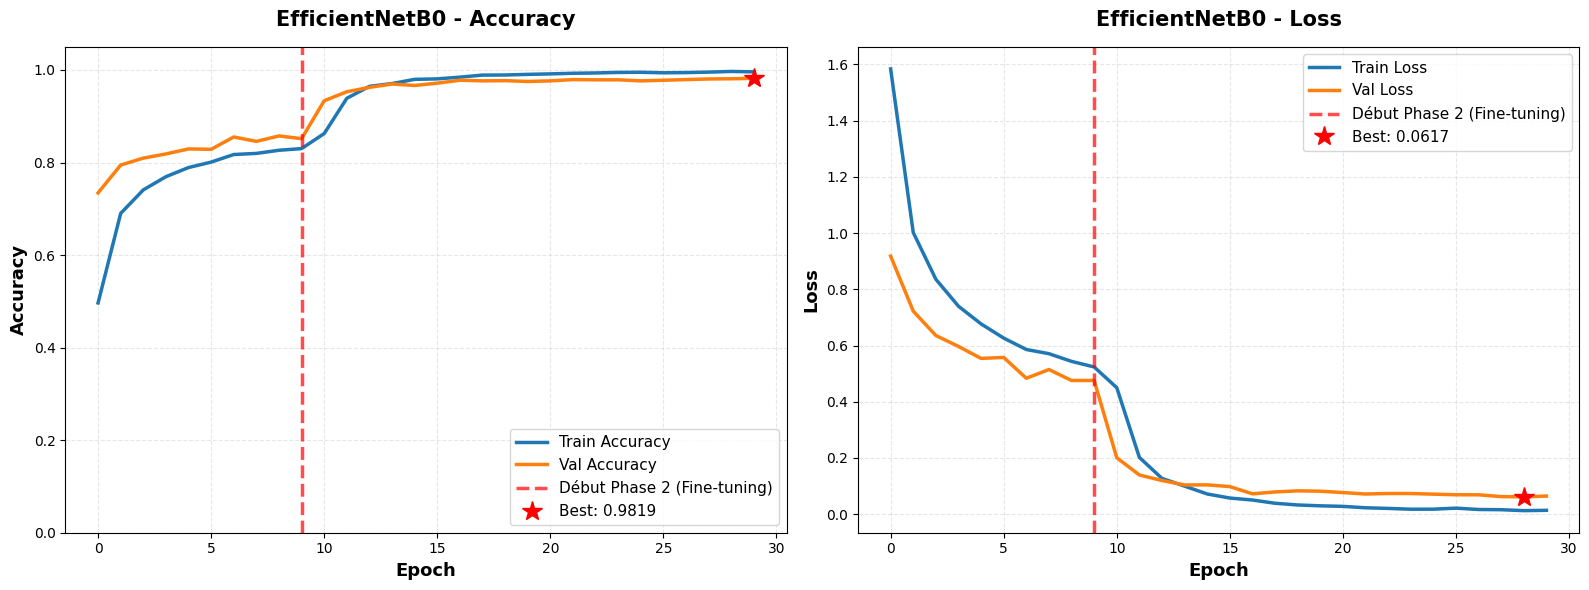

Phase 1 (Head Only):
  - Epochs : 10
  - Temps : 46.8 minutes
  - Meilleure Val Acc : 0.8575

Phase 2 (Fine-tuning):
  - Epochs : 20
  - Temps : 138.8 minutes
  - Meilleure Val Acc : 0.9819

RÉSULTAT FINAL:
   Val Accuracy : 0.9819
   Val Loss : 0.0617
   Temps Total : 185.6 minutes


In [84]:

# Combinaison  des historiques Phase 1 et Phase 2
combined_history = {
    'accuracy': history_p1.history['accuracy'] + history_p2.history['accuracy'],
    'val_accuracy': history_p1.history['val_accuracy'] + history_p2.history['val_accuracy'],
    'loss': history_p1.history['loss'] + history_p2.history['loss'],
    'val_loss': history_p1.history['val_loss'] + history_p2.history['val_loss']
}

# Nombre d'epochs de la Phase 1
epochs_phase1 = len(history_p1.history['accuracy'])
epochs_total = len(combined_history['accuracy'])

# Creation du  graphique
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


# GRAPHIQUE 1 : ACCURACY


ax1.plot(combined_history['accuracy'], label='Train Accuracy', linewidth=2.5, color='#1f77b4')
ax1.plot(combined_history['val_accuracy'], label='Val Accuracy', linewidth=2.5, color='#ff7f0e')

# Ligne verticale séparant Phase 1 et Phase 2
ax1.axvline(x=epochs_phase1-1, color='red', linestyle='--', linewidth=2.5, 
            label='Début Phase 2 (Fine-tuning)', alpha=0.7)

# Annotations
max_val_acc = max(combined_history['val_accuracy'])
max_val_epoch = combined_history['val_accuracy'].index(max_val_acc)
ax1.plot(max_val_epoch, max_val_acc, 'r*', markersize=15, 
         label=f'Best: {max_val_acc:.4f}')

ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('EfficientNetB0 - Accuracy', fontsize=15, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1.05])


# GRAPHIQUE 2 : LOSS

ax2.plot(combined_history['loss'], label='Train Loss', linewidth=2.5, color='#1f77b4')
ax2.plot(combined_history['val_loss'], label='Val Loss', linewidth=2.5, color='#ff7f0e')

# Ligne verticale séparant Phase 1 et Phase 2
ax2.axvline(x=epochs_phase1-1, color='red', linestyle='--', linewidth=2.5, 
            label='Début Phase 2 (Fine-tuning)', alpha=0.7)

# Annotations
min_val_loss = min(combined_history['val_loss'])
min_loss_epoch = combined_history['val_loss'].index(min_val_loss)
ax2.plot(min_loss_epoch, min_val_loss, 'r*', markersize=15, 
         label=f'Best: {min_val_loss:.4f}')

ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax2.set_title('EfficientNetB0 - Loss', fontsize=15, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3, linestyle='--')

# sauvegarde du graphique
plt.tight_layout()
save_path = FIGURES_DIR / 'efficientnet_training.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f" Graphique sauvegardé dans  : {save_path}")
plt.show()


# resume 

print(f"Phase 1 (Head Only):")
print(f"  - Epochs : {epochs_phase1}")
print(f"  - Temps : {temps_p1/60:.1f} minutes")
print(f"  - Meilleure Val Acc : {max(history_p1.history['val_accuracy']):.4f}")
print()
print(f"Phase 2 (Fine-tuning):")
print(f"  - Epochs : {len(history_p2.history['accuracy'])}")
print(f"  - Temps : {temps_p2/60:.1f} minutes")
print(f"  - Meilleure Val Acc : {max(history_p2.history['val_accuracy']):.4f}")
print()
print(f"RÉSULTAT FINAL:")
print(f"   Val Accuracy : {max(combined_history['val_accuracy']):.4f}")
print(f"   Val Loss : {min(combined_history['val_loss']):.4f}")
print(f"   Temps Total : {(temps_p1 + temps_p2)/60:.1f} minutes")


# SECTION 9 :  ÉVALUATION & COMPARAISON DES MODÈLES

In [98]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

from pathlib import Path

print("Comparaison : CNN from Scratch vs EfficientNetB0")

print()
print(" Imports OK")
print()

Comparaison : CNN from Scratch vs EfficientNetB0

 Imports OK



In [99]:
#préparation des données de validation 


print("Chargement des données de validation...")

print()


# GENERATEUR 1 : Pour CNN Scratch (rescale simple)


val_datagen_cnn = ImageDataGenerator(rescale=1./255)

val_gen_cnn = val_datagen_cnn.flow_from_directory(
    PROCESSED_VAL_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f" Generateur CNN : {val_gen_cnn.samples} images")

# Charger les images pour CNN
X_test_cnn = []
y_test_cnn = []

print("Chargement des images pour CNN...")
for i in range(len(val_gen_cnn)):
    batch_x, batch_y = val_gen_cnn[i]
    X_test_cnn.extend(batch_x)
    y_test_cnn.extend(batch_y)
    
    if (i + 1) % 20 == 0:
        print(f"  {i+1}/{len(val_gen_cnn)} batches chargés...")

X_test_cnn = np.array(X_test_cnn)
y_test_cnn = np.array(y_test_cnn)

print()


# GENERATEUR 2 : Pour EfficientNet (preprocessing spécifique)


from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

val_datagen_eff = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess  
)

val_gen_eff = val_datagen_eff.flow_from_directory(
    PROCESSED_VAL_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f" generateurs de  EfficientNet : {val_gen_eff.samples} images")

# Charger les images pour EfficientNet
X_test_eff = []
y_test_eff = []

print("Chargement des images pour EfficientNet...")
for i in range(len(val_gen_eff)):
    batch_x, batch_y = val_gen_eff[i]
    X_test_eff.extend(batch_x)
    y_test_eff.extend(batch_y)
    
    if (i + 1) % 20 == 0:
        print(f"  {i+1}/{len(val_gen_eff)} batches chargés...")

X_test_eff = np.array(X_test_eff)
y_test_eff = np.array(y_test_eff)

# Labels (identiques pour les deux modeles )
y_test_labels = np.argmax(y_test_cnn, axis=1)

print()
print(f" Données chargées")
print(f"   CNN : {X_test_cnn.shape}")
print(f"   EfficientNet : {X_test_eff.shape}")
print(f"   Labels : {y_test_labels.shape}")
print()

Chargement des données de validation...

Found 2210 images belonging to 13 classes.
 Generateur CNN : 2210 images
Chargement des images pour CNN...
  20/70 batches chargés...
  40/70 batches chargés...
  60/70 batches chargés...

Found 2210 images belonging to 13 classes.
 generateurs de  EfficientNet : 2210 images
Chargement des images pour EfficientNet...
  20/70 batches chargés...
  40/70 batches chargés...
  60/70 batches chargés...

 Données chargées
   CNN : (2210, 224, 224, 3)
   EfficientNet : (2210, 224, 224, 3)
   Labels : (2210,)



In [100]:
# chargement des modeles 


print("Chargement des modeles entrainés...")

print()

# Importe de accuracy_score pour la  vérification rapide
from sklearn.metrics import accuracy_score

# CNN Scratch
cnn_model = keras.models.load_model(MODELS_DIR / "cnn_scratch.keras")
print(" CNN Scratch chargé")
print(f"   Paramètres : {cnn_model.count_params():,}")

# EfficientNet
efficientnet_model = keras.models.load_model(MODELS_DIR / "efficientnet_final.keras")
print(" EfficientNetB0 chargé")
print(f"   Paramètres : {efficientnet_model.count_params():,}")

print()

Chargement des modeles entrainés...

 CNN Scratch chargé
   Paramètres : 19,271,885
 EfficientNetB0 chargé
   Paramètres : 4,380,848



In [101]:
#predictions 


print("Generation des predictions...")

print()

# CNN Scratch avec X_test_cnn
print("CNN Scratch...")
y_pred_cnn = cnn_model.predict(X_test_cnn, verbose=1, batch_size=32)
y_pred_cnn_labels = np.argmax(y_pred_cnn, axis=1)
print(" CNN terminé")
print(f"   Accuracy : {accuracy_score(y_test_labels, y_pred_cnn_labels):.4f}")
print()

# EfficientNet avec X_test_eff
print("EfficientNetB0...")
y_pred_eff = efficientnet_model.predict(X_test_eff, verbose=1, batch_size=32)
y_pred_eff_labels = np.argmax(y_pred_eff, axis=1)
print(" EfficientNet terminé")
print(f"   Accuracy : {accuracy_score(y_test_labels, y_pred_eff_labels):.4f}")
print()

Generation des predictions...

CNN Scratch...
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 388ms/step
 CNN terminé
   Accuracy : 0.8986

EfficientNetB0...
70/70 ━━━━━━━━━━━━━━━━━━━━ 50s 627ms/step
 EfficientNet terminé
   Accuracy : 0.9819



In [102]:
# Rapports de classification
print(" RAPPORTS DE CLASSIFICATION")

print()


print("CNN FROM SCRATCH")

print()
report_cnn = classification_report(
    y_test_labels, 
    y_pred_cnn_labels, 
    target_names=CLASSES, 
    digits=4,
    zero_division=0
)
print(report_cnn)
print()


print("EFFICIENTNETB0")

print()
report_eff = classification_report(
    y_test_labels, 
    y_pred_eff_labels, 
    target_names=CLASSES, 
    digits=4,
    zero_division=0
)
print(report_eff)
print()

# Sauvegarde des rapports
reports_dir = OUTPUTS_DIR / 'reports'
reports_dir.mkdir(parents=True, exist_ok=True)

with open(reports_dir / 'classification_report_cnn.txt', 'w', encoding='utf-8') as f:
    f.write("CNN FROM SCRATCH - CLASSIFICATION REPORT\n")
    f.write("\n\n")
    f.write(report_cnn)

with open(reports_dir / 'classification_report_efficientnet.txt', 'w', encoding='utf-8') as f:
    f.write("EFFICIENTNETB0 - CLASSIFICATION REPORT\n")
    f.write("\n\n")
    f.write(report_eff)

print(f"les  rapports  sont sauvegardés dans {reports_dir}")
print()

 RAPPORTS DE CLASSIFICATION

CNN FROM SCRATCH

                          precision    recall  f1-score   support

  abraham_grampa_simpson     0.9162    0.9000    0.9080       170
            bart_simpson     0.8121    0.7882    0.8000       170
charles_montgomery_burns     0.8647    0.8647    0.8647       170
            chief_wiggum     0.8939    0.9412    0.9169       170
           homer_simpson     0.8675    0.8471    0.8571       170
        krusty_the_clown     0.9581    0.9412    0.9496       170
            lisa_simpson     0.7725    0.8588    0.8134       170
           marge_simpson     0.9357    0.9412    0.9384       170
     milhouse_van_houten     0.9529    0.9529    0.9529       170
             moe_szyslak     0.8931    0.8353    0.8632       170
            ned_flanders     0.9810    0.9118    0.9451       170
       principal_skinner     0.9512    0.9176    0.9341       170
            sideshow_bob     0.9027    0.9824    0.9408       170

                accuracy   

 CRÉATION DES MATRICES DE CONFUSION

Création matrice CNN...
 Matrice de confusion sauvegardée  dans : confusion_matrix_cnn.png


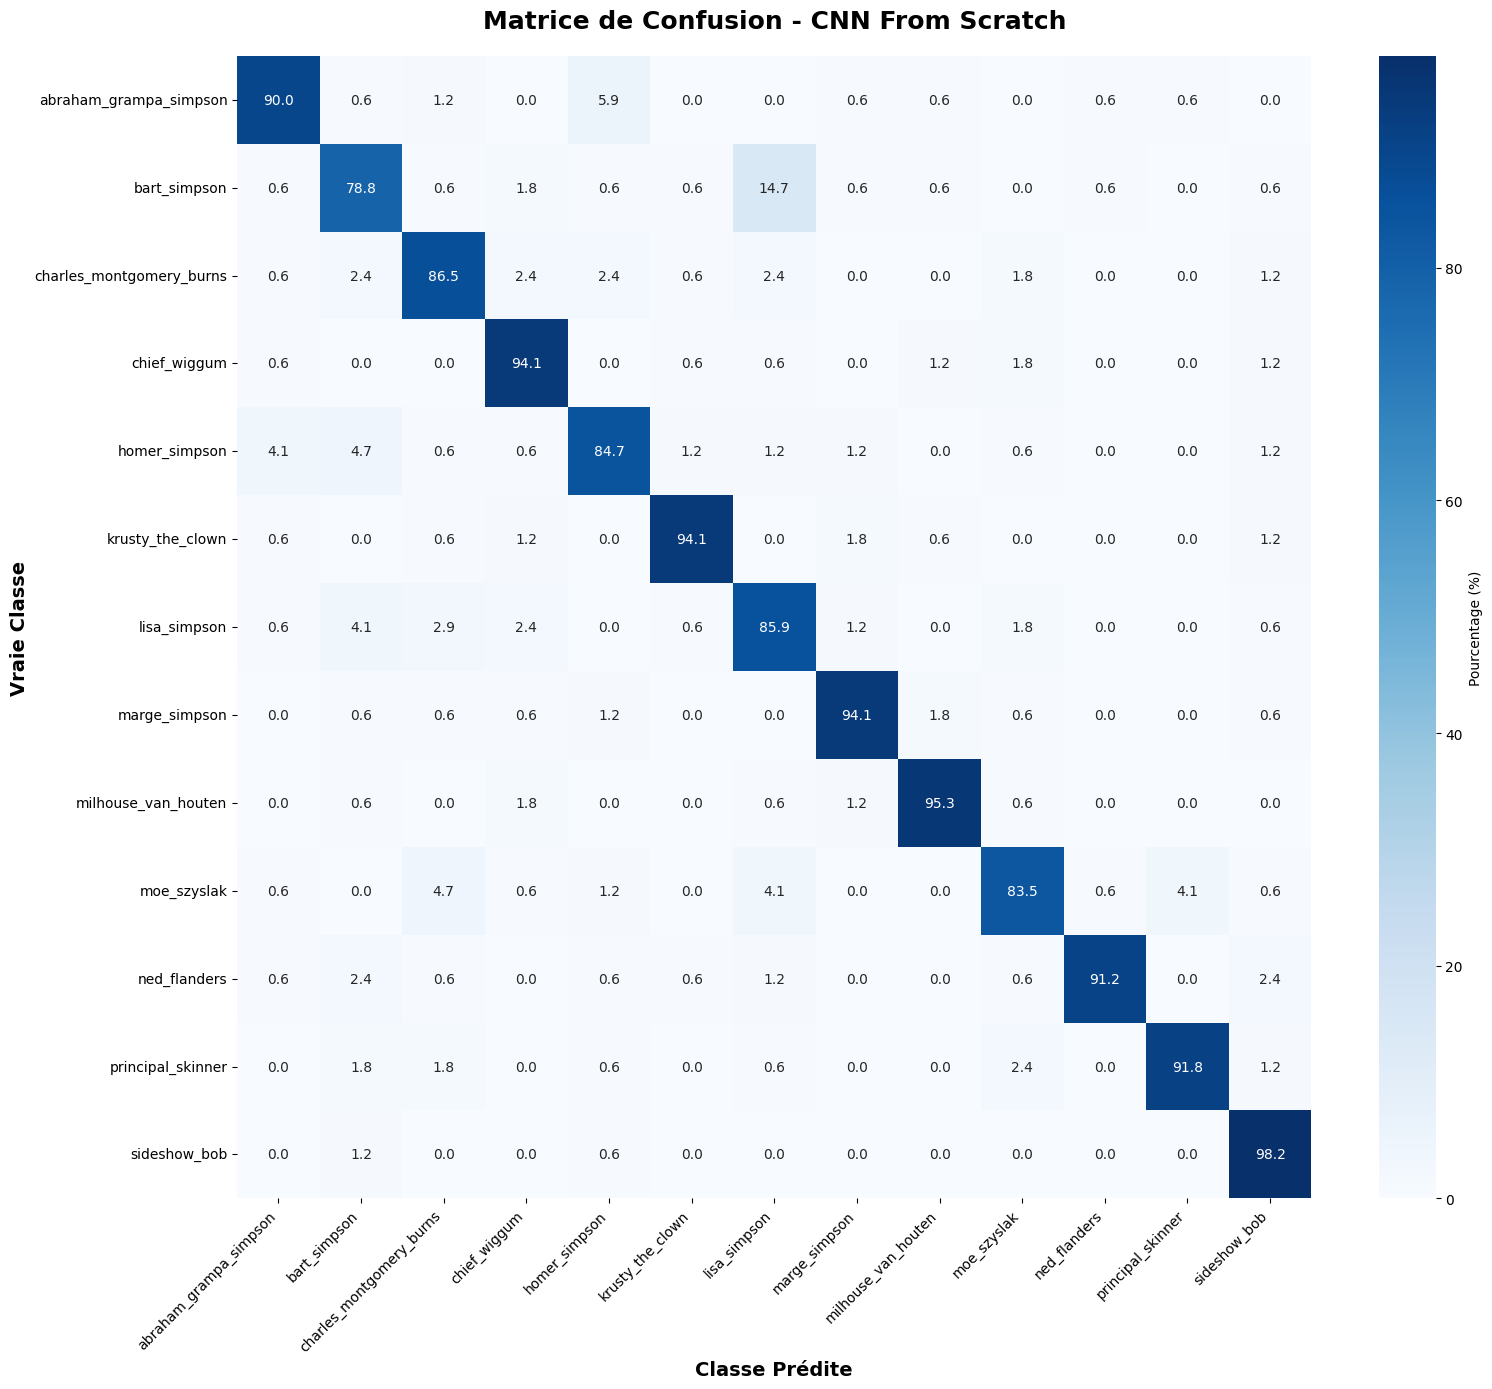

   Accuracy globale : 0.8986 (89.86%)
   Meilleure classe : sideshow_bob (98.2%)
   Pire classe      : bart_simpson (78.8%)

Creation matrice EfficientNet...
 Matrice de confusion sauvegardée  dans : confusion_matrix_efficientnet.png


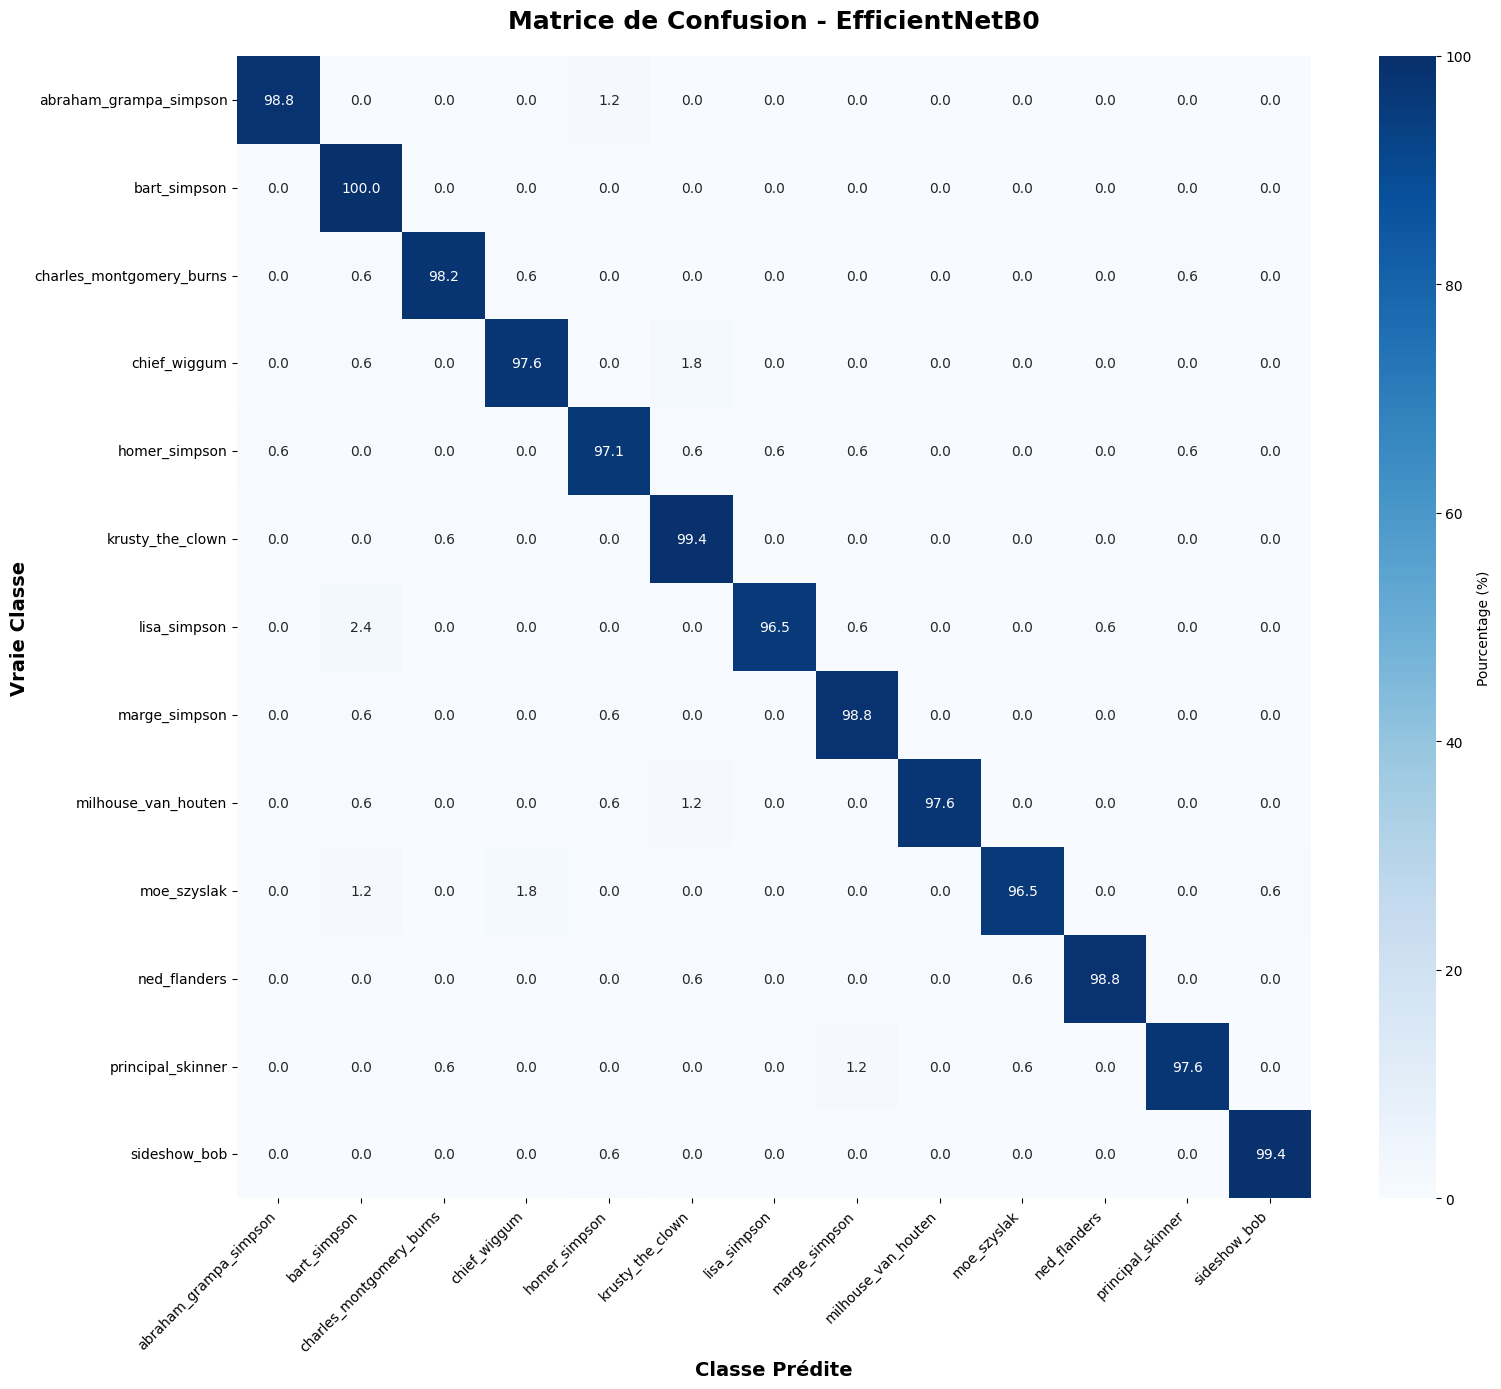

   Accuracy globale : 0.9819 (98.19%)
   Meilleure classe : bart_simpson (100.0%)
   Pire classe      : lisa_simpson (96.5%)



In [103]:
# Matrices de confusion
print(" CRÉATION DES MATRICES DE CONFUSION")

print()

def plot_confusion_matrix(y_true, y_pred, classes, title, filename):
    """Créer et sauvegarder une matrice de confusion"""
    cm = confusion_matrix(y_true, y_pred)
    
    # Calcul des pourcentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(16, 14))
    
    # Creation  du heatmap avec les pourcentages
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Pourcentage (%)'})
    
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.ylabel('Vraie Classe', fontsize=14, fontweight='bold')
    plt.xlabel('Classe Prédite', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    plt.tight_layout()
    save_path = FIGURES_DIR / filename
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f" Matrice de confusion sauvegardée  dans : {filename}")
    plt.show()
    
    # Statistiques de la matrice
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"   Accuracy globale : {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Classes les mieux et moins bien classées
    diag = np.diag(cm_percent)
    best_class = classes[np.argmax(diag)]
    worst_class = classes[np.argmin(diag)]
    print(f"   Meilleure classe : {best_class} ({np.max(diag):.1f}%)")
    print(f"   Pire classe      : {worst_class} ({np.min(diag):.1f}%)")
    print()

# CNN Scratch
print("Création matrice CNN...")
plot_confusion_matrix(
    y_test_labels, y_pred_cnn_labels, CLASSES,
    'Matrice de Confusion - CNN From Scratch',
    'confusion_matrix_cnn.png'
)

# EfficientNet
print("Creation matrice EfficientNet...")
plot_confusion_matrix(
    y_test_labels, y_pred_eff_labels, CLASSES,
    'Matrice de Confusion - EfficientNetB0',
    'confusion_matrix_efficientnet.png'
)

 GRAPHIQUE COMPARATIF

 Graphique sauvegardé  dans : A:\Mes documents\CNN\outputs\figures\comparison_models.png


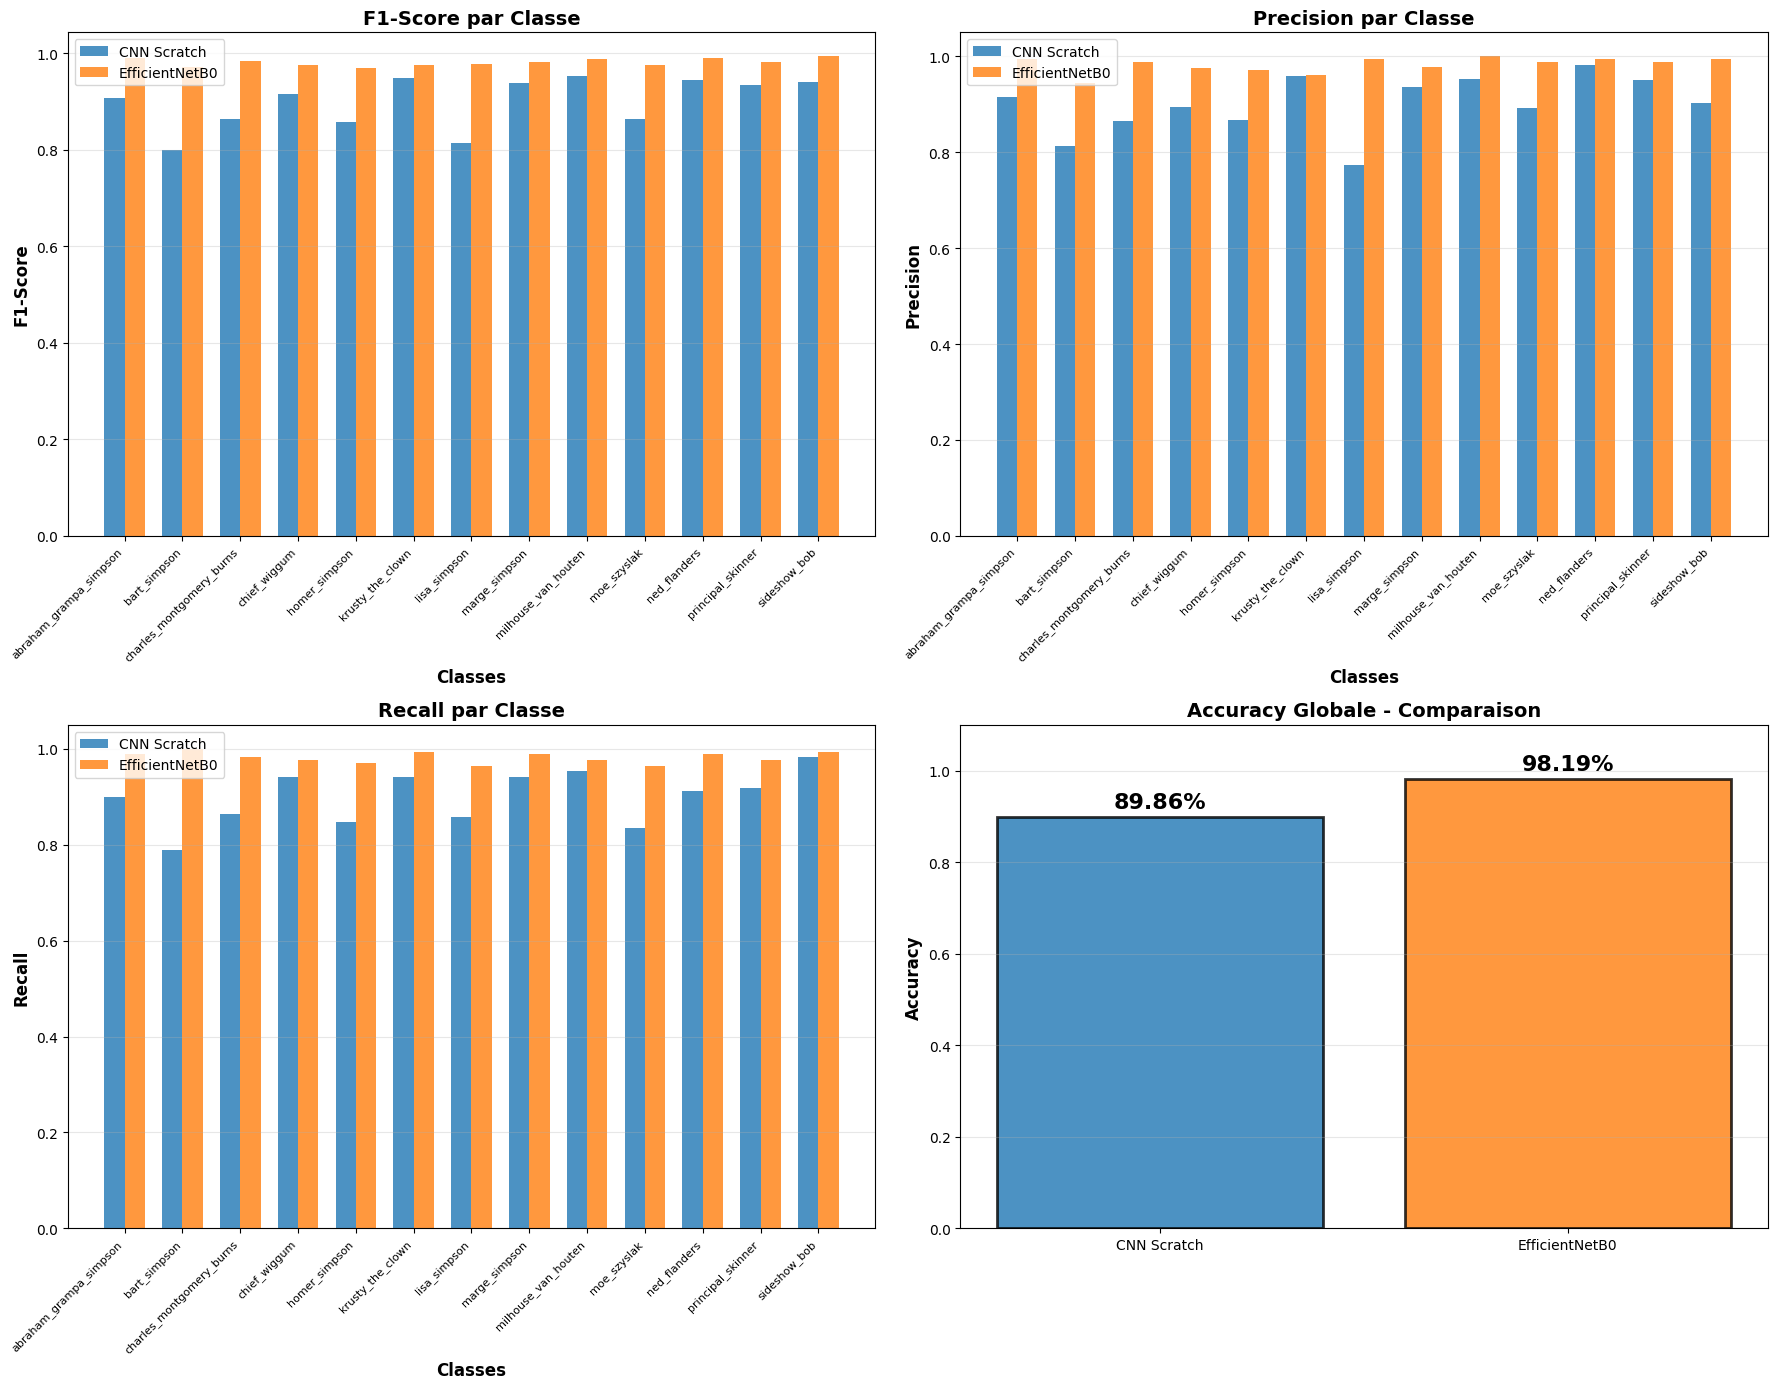

In [104]:
#  comparaison viduel des deux modeles 

print(" GRAPHIQUE COMPARATIF")

print()

# Calcul des métriques par classe pour chaque modele
from sklearn.metrics import precision_recall_fscore_support

# CNN
precision_cnn, recall_cnn, f1_cnn, _ = precision_recall_fscore_support(
    y_test_labels, y_pred_cnn_labels, average=None, labels=range(len(CLASSES)),
    zero_division=0
)

# EfficientNet
precision_eff, recall_eff, f1_eff, _ = precision_recall_fscore_support(
    y_test_labels, y_pred_eff_labels, average=None, labels=range(len(CLASSES)),
    zero_division=0
)

# Creation  de graphique
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# F1-Score par classe
ax = axes[0, 0]
x = np.arange(len(CLASSES))
width = 0.35
ax.bar(x - width/2, f1_cnn, width, label='CNN Scratch', alpha=0.8, color='#1f77b4')
ax.bar(x + width/2, f1_eff, width, label='EfficientNetB0', alpha=0.8, color='#ff7f0e')
ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('F1-Score par Classe', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASSES, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Precision par classe
ax = axes[0, 1]
ax.bar(x - width/2, precision_cnn, width, label='CNN Scratch', alpha=0.8, color='#1f77b4')
ax.bar(x + width/2, precision_eff, width, label='EfficientNetB0', alpha=0.8, color='#ff7f0e')
ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision par Classe', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASSES, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Recall par classe
ax = axes[1, 0]
ax.bar(x - width/2, recall_cnn, width, label='CNN Scratch', alpha=0.8, color='#1f77b4')
ax.bar(x + width/2, recall_eff, width, label='EfficientNetB0', alpha=0.8, color='#ff7f0e')
ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax.set_title('Recall par Classe', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASSES, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Barplot comparatif global
ax = axes[1, 1]
models = ['CNN Scratch', 'EfficientNetB0']
accuracies = [
    accuracy_score(y_test_labels, y_pred_cnn_labels),
    accuracy_score(y_test_labels, y_pred_eff_labels)
]
colors = ['#1f77b4', '#ff7f0e']

bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Ajout des valeurs au-dessus des barres
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{acc:.2%}',
            ha='center', va='bottom', fontsize=16, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Globale - Comparaison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_path = FIGURES_DIR / 'comparison_models.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f" Graphique sauvegardé  dans : {save_path}")
plt.show()

In [105]:
#tableau comparatif final 


print(" TABLEAU COMPARATIF FINAL")

print()

# Calcul de  toutes les métriques
metrics_data = []

for model_name, y_pred in [
    ('CNN Scratch', y_pred_cnn_labels),
    ('EfficientNetB0', y_pred_eff_labels)
]:
    acc = accuracy_score(y_test_labels, y_pred)
    prec = precision_score(y_test_labels, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test_labels, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_labels, y_pred, average='weighted', zero_division=0)
    
    metrics_data.append({
        'Modèle': model_name,
        'Accuracy': f'{acc:.4f}',
        'Precision': f'{prec:.4f}',
        'Recall': f'{rec:.4f}',
        'F1-Score': f'{f1:.4f}',
        'Accuracy %': f'{acc*100:.2f}%'
    })

df_metrics = pd.DataFrame(metrics_data)
print(df_metrics.to_string(index=False))
print()

# Sauvegarder le tableau
csv_path = reports_dir / 'final_comparison.csv'
df_metrics.to_csv(csv_path, index=False)
print(f" Tableau sauvegardé  dans : {csv_path}")
print()

# Gain Transfer Learning
gain = (accuracies[1] - accuracies[0]) * 100
print(f" Gain Transfer Learning : +{gain:.2f} points de pourcentage")
print()

 TABLEAU COMPARATIF FINAL

        Modèle Accuracy Precision Recall F1-Score Accuracy %
   CNN Scratch   0.8986    0.9001 0.8986   0.8988     89.86%
EfficientNetB0   0.9819    0.9822 0.9819   0.9819     98.19%

 Tableau sauvegardé  dans : A:\Mes documents\CNN\outputs\reports\final_comparison.csv

 Gain Transfer Learning : +8.33 points de pourcentage



In [106]:
# Analyse des erreurs , top 5 des confusions

print(" ANALYSE DES ERREURS")

print()

def analyze_errors(y_true, y_pred, classes, model_name):
    """Analyser les principales confusions"""
    print(f"\n{model_name} - Top 5 Confusions:")
    print("-" * 60)
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Trouver les confusions (hors diagonale)
    confusions = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            if i != j and cm[i, j] > 0:
                confusions.append((classes[i], classes[j], cm[i, j]))
    
    # Trier par nombre de confusions
    confusions.sort(key=lambda x: x[2], reverse=True)
    
    # Afficher le  top 5
    if len(confusions) > 0:
        for idx, (true_class, pred_class, count) in enumerate(confusions[:5], 1):
            print(f"{idx}. {true_class:30s} → {pred_class:30s} : {count:3d} erreurs")
    else:
        print("   Aucune confusion ! Classification parfaite ! ")
    
    print()

# Analyse des deux modèles
analyze_errors(y_test_labels, y_pred_cnn_labels, CLASSES, "CNN Scratch")
analyze_errors(y_test_labels, y_pred_eff_labels, CLASSES, "EfficientNetB0")

 ANALYSE DES ERREURS


CNN Scratch - Top 5 Confusions:
------------------------------------------------------------
1. bart_simpson                   → lisa_simpson                   :  25 erreurs
2. abraham_grampa_simpson         → homer_simpson                  :  10 erreurs
3. homer_simpson                  → bart_simpson                   :   8 erreurs
4. moe_szyslak                    → charles_montgomery_burns       :   8 erreurs
5. homer_simpson                  → abraham_grampa_simpson         :   7 erreurs


EfficientNetB0 - Top 5 Confusions:
------------------------------------------------------------
1. lisa_simpson                   → bart_simpson                   :   4 erreurs
2. chief_wiggum                   → krusty_the_clown               :   3 erreurs
3. moe_szyslak                    → chief_wiggum                   :   3 erreurs
4. abraham_grampa_simpson         → homer_simpson                  :   2 erreurs
5. milhouse_van_houten            → krusty_the_clown     

In [107]:
# Classement final
print(" CLASSEMENT FINAL")

print()

# Tri par accuracy
results = [
    ('CNN Scratch', accuracy_score(y_test_labels, y_pred_cnn_labels)),
    ('EfficientNetB0', accuracy_score(y_test_labels, y_pred_eff_labels))
]
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

medals = ['1', '2']
for i, (model, acc) in enumerate(results_sorted):
    print(f"{medals[i]} {i+1}. {model:20s} : {acc:.4f} ({acc*100:.2f}%)")


# Résumé final
print(" RÉSUMÉ FINAL DU PROJET")

print(f"Dataset utilisé      : 11,050 images (850/classe)")
print(f"Classes              : 13 personnages Simpsons")
print(f"Split                : 80% train (8,840) / 20% val (2,210)")
print(f"Modèles entraînés    : 2 (CNN Scratch + EfficientNetB0)")
print(f"Meilleur modèle      : {results_sorted[0][0]}")
print(f"Meilleure accuracy   : {results_sorted[0][1]*100:.2f}%")
print(f"Gain Transfer Learn. : +{gain:.2f}%")
print()
print("Fichiers générés:")
print(f"  - Modèles          : {MODELS_DIR}")
print(f"  - Graphiques       : {FIGURES_DIR}")
print(f"  - Rapports         : {reports_dir}")


# Créer un fichier récapitulatif
summary_path = reports_dir / 'project_summary.txt'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write( "\n")
    f.write("RÉSUMÉ FINAL DU PROJET - CNN SIMPSONS CLASSIFICATION\n")
    f.write( "\n\n")
    f.write(f"Dataset utilisé      : 11,050 images (850/classe)\n")
    f.write(f"Classes              : 13 personnages Simpsons\n")
    f.write(f"Split                : 80% train (8,840) / 20% val (2,210)\n")
    f.write(f"Modèles entraînés    : 2 (CNN Scratch + EfficientNetB0)\n\n")
    f.write("RÉSULTATS:\n")
    f.write(f"  CNN Scratch      : {results[0][1]*100:.2f}%\n")
    f.write(f"  EfficientNetB0   : {results[1][1]*100:.2f}%\n")
    f.write(f"  Gain TL          : +{gain:.2f}%\n\n")
    f.write(f"Meilleur modèle    : {results_sorted[0][0]} ({results_sorted[0][1]*100:.2f}%)\n")

print(f" Résumé sauvegardé  dans : {summary_path}")

 CLASSEMENT FINAL

1 1. EfficientNetB0       : 0.9819 (98.19%)
2 2. CNN Scratch          : 0.8986 (89.86%)
 RÉSUMÉ FINAL DU PROJET
Dataset utilisé      : 11,050 images (850/classe)
Classes              : 13 personnages Simpsons
Split                : 80% train (8,840) / 20% val (2,210)
Modèles entraînés    : 2 (CNN Scratch + EfficientNetB0)
Meilleur modèle      : EfficientNetB0
Meilleure accuracy   : 98.19%
Gain Transfer Learn. : +8.33%

Fichiers générés:
  - Modèles          : A:\Mes documents\CNN\models
  - Graphiques       : A:\Mes documents\CNN\outputs\figures
  - Rapports         : A:\Mes documents\CNN\outputs\reports
 Résumé sauvegardé  dans : A:\Mes documents\CNN\outputs\reports\project_summary.txt
